# MLP

Coding RNA. MLP with one neuron. All K-mers, K=4, one byte counts with cap 255. Threshold=mean (fair test, not Gudenas). No scaling. 5-fold CV. RCI from cell line 0 = A549.

Cross validation acc mean 68.26% (+/- 1.13%) on binary classification of all mRNA. 

We ran 20 epochs but 5 would suffice. There was no overfitting with such a simple model.

## Environment setup

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-10-21 08:57:38.160726
Python 3.10.0
sklearn 1.1.2


In [2]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import LayerNormalization
from sklearn.preprocessing import StandardScaler

dt='float32'
tf.keras.backend.set_floatx(dt)

tf.random.set_seed(42) # reproducible training sessions?

from KmerCounter import KmerCounter
ALPHABET_SIZE=4
K=4
counter=KmerCounter(K)
VOCABULARY_SIZE = counter.get_vocabulary_size() 
print('K=',K,'alphabet size=',ALPHABET_SIZE,'vocabulary size=',VOCABULARY_SIZE)
from TrainValidSplit2 import Splitter2
EPOCHS=20
from cell_lines import Cell_Lines
CELL_LINE_NUMBER = 0

K= 4 alphabet size= 4 vocabulary size= 256


In [3]:
ATLAS_DIR = '/Users/jasonmiller/WVU/Localization/LncAtlas/'
RCI_FILE = 'CNRCI_coding_train_genes.csv'
GENCODE_DIR = '/Users/jasonmiller/WVU/Localization/GenCode/'
COUNTS_FILE='CNRCI_coding_train_counts.K4.csv'

In [4]:
# Consider a Cell_Lines object to represent today's cell line.
all_cell_lines = Cell_Lines.get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 0 = A549


## Model design

In [5]:
def build_model():
    # Here is the joke model -- one neuron!
    mlp = keras.models.Sequential()
    one_layer = keras.layers.Dense(1, activation='sigmoid',dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    mlp.add(one_layer)
      
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    print("...COMPILED")
    return mlp

In [6]:
# Model setup
print(datetime.now())
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once

2022-10-21 08:57:58.916840
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________
None


2022-10-21 08:57:58.949822: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the data

In [7]:
# Data setup
print(datetime.now())
Kmer_counts_filepath = GENCODE_DIR+COUNTS_FILE
atlas_filepath = ATLAS_DIR+RCI_FILE

splitter=Splitter2()
splitter.load_counts_universe(Kmer_counts_filepath)
universe = splitter.get_gene_universe(atlas_filepath, CELL_LINE_NUMBER)
print(datetime.now())

2022-10-21 08:57:59.182425
Loaded values for cell line 0
Selected 10354 values out of 13930
2022-10-21 08:58:02.309222


## Train and validate with all K-mer counts

In [8]:
SCALING = False
def do_cross_validation(splitter,eps):
    cv_scores = []
    fold=0
    print(datetime.now())
    print('splitting')
    data_partitions = splitter.get_train_valid_partitions(universe)
    for one_partition in data_partitions:
        train_genes,valid_genes = one_partition[0],one_partition[1]
        thresholds = splitter.choose_thresholds(train_genes,'mean')
        X_train,y_train,train_ids = splitter.get_X_y(train_genes, thresholds)
        X_valid,y_valid,valid_ids = splitter.get_X_y(valid_genes, thresholds)

        if SCALING:
            print('scaling')
            print(datetime.now())
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_valid = scaler.transform(X_valid)

        fold += 1
        print('Fold',fold)
        print('Train sizes',len(X_train),len(y_train))
        print('Valid sizes',len(X_valid),len(y_valid))
        print('Thresholds',thresholds)
        print('Train set ones/size',
              np.count_nonzero(y_train),'/',len(y_train))
        print('Valid set ones/size',
              np.count_nonzero(y_valid),'/',len(y_valid))

        print("BUILD MODEL")
        model=build_model()

        print("FIT")
        print(datetime.now())
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        print("Compute valiation accuracy")
        print(datetime.now())
        scores = model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        print(datetime.now())
        cv_scores.append(scores[1] * 100)
    print()
    print("Cross validation acc mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))


2022-10-21 08:59:10.587396
2022-10-21 08:59:10.588174
splitting
Fold 1
Train sizes 43098 43098
Valid sizes 11253 11253
Thresholds (-0.06339805672404636, -0.06339805672404636)
Train set ones/size 22203 / 43098
Valid set ones/size 6149 / 11253
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-10-21 08:59:10.795068
Epoch 1/20
1347/1347 [==============================] - 4s 2ms/step - loss: 1.0401 - accuracy: 0.6054 - val_loss: 0.8152 - val_accuracy: 0.5957
Epoch 2/20
1347/1347 [==============================] - 3s 2ms/step - loss: 0.6676 - accuracy: 0.6604 - val_loss: 0.6384 - val_accuracy: 0.6885
Epoch 3/20
1347/1347 [==============================] - 3s 2ms/step - loss: 0.6259 - accuracy: 0.6785 - val_loss: 0.7624 - val_accuracy: 0.6269
Epoch 4/20
1347/1347 [==============================] - 3s 2ms/step - loss: 0.6238 - accuracy: 0.6786 - val_loss: 0.6172 - val_accuracy: 0.6820
Epoch 5/20
1347/1347 [==============================] - 3s 2ms/step - loss: 0.6085 - accuracy: 0.6834 - val_loss: 0.

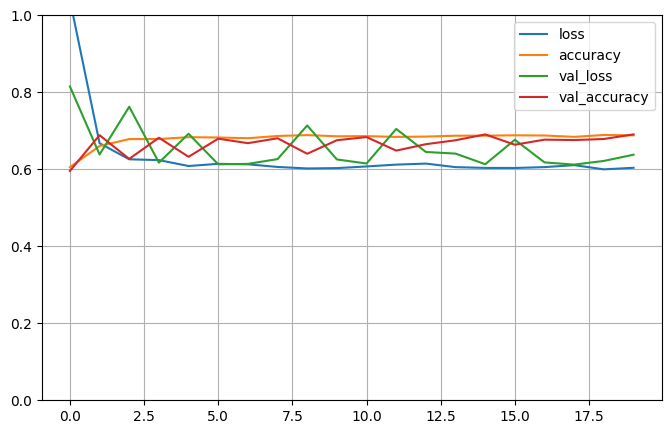

Compute valiation accuracy
2022-10-21 09:00:10.336195
accuracy: 69.06%
2022-10-21 09:00:11.014855
Fold 2
Train sizes 43483 43483
Valid sizes 10868 10868
Thresholds (-0.051316687318445194, -0.051316687318445194)
Train set ones/size 22392 / 43483
Valid set ones/size 5710 / 10868
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-10-21 09:00:11.174811
Epoch 1/20
1359/1359 [==============================] - 4s 2ms/step - loss: 0.9416 - accuracy: 0.6167 - val_loss: 0.7927 - val_accuracy: 0.6309
Epoch 2/20
1359/1359 [==============================] - 3s 2ms/step - loss: 0.6564 - accuracy: 0.6651 - val_loss: 0.6520 - val_accuracy: 0.6654
Epoch 3/20
1359/1359 [==============================] - 3s 2ms/step - loss: 0.6213 - accuracy: 0.6796 - val_loss: 0.7011 - val_accuracy: 0.6358
Epoch 4/20
1359/1359 [==============================] - 4s 3ms/step - loss: 0.6143 - accuracy: 0.6833 - val_loss: 0.6740 - val_accuracy: 0.6526
Epoch 5/20
1359/1359 [==============================] - 3s 2ms/step - loss: 0.60

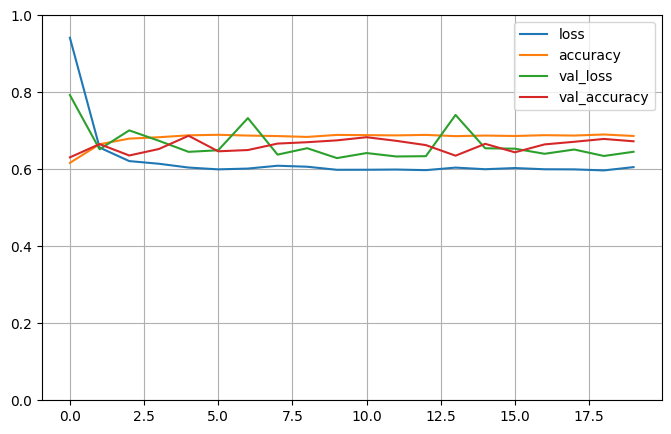

Compute valiation accuracy
2022-10-21 09:01:09.635961
accuracy: 67.27%
2022-10-21 09:01:10.050847
Fold 3
Train sizes 43451 43451
Valid sizes 10900 10900
Thresholds (-0.051095313668638336, -0.051095313668638336)
Train set ones/size 22477 / 43451
Valid set ones/size 5625 / 10900
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-10-21 09:01:10.169500
Epoch 1/20
1358/1358 [==============================] - 3s 2ms/step - loss: 0.9281 - accuracy: 0.6063 - val_loss: 0.8028 - val_accuracy: 0.6340
Epoch 2/20
1358/1358 [==============================] - 3s 2ms/step - loss: 0.6541 - accuracy: 0.6642 - val_loss: 0.6760 - val_accuracy: 0.6599
Epoch 3/20
1358/1358 [==============================] - 3s 2ms/step - loss: 0.6119 - accuracy: 0.6844 - val_loss: 0.6709 - val_accuracy: 0.6721
Epoch 4/20
1358/1358 [==============================] - 3s 2ms/step - loss: 0.6139 - accuracy: 0.6852 - val_loss: 0.6556 - val_accuracy: 0.6812
Epoch 5/20
1358/1358 [==============================] - 3s 2ms/step - loss: 0.60

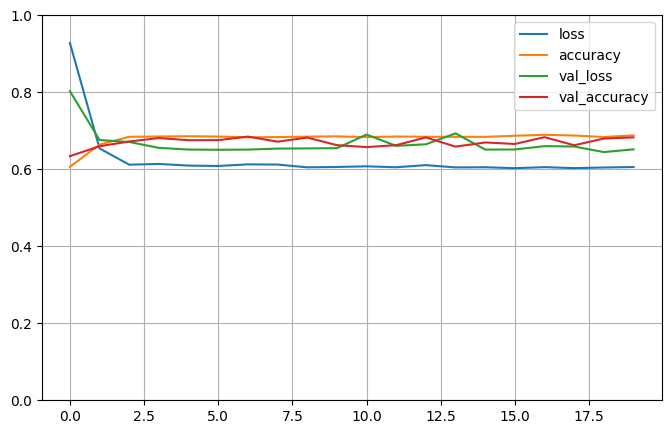

Compute valiation accuracy
2022-10-21 09:02:08.224236
accuracy: 68.28%
2022-10-21 09:02:08.842880
Fold 4
Train sizes 43564 43564
Valid sizes 10787 10787
Thresholds (-0.047797078149324, -0.047797078149324)
Train set ones/size 22724 / 43564
Valid set ones/size 5320 / 10787
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-10-21 09:02:08.969098
Epoch 1/20
1362/1362 [==============================] - 4s 2ms/step - loss: 0.9081 - accuracy: 0.6228 - val_loss: 0.7848 - val_accuracy: 0.6363
Epoch 2/20
1362/1362 [==============================] - 3s 2ms/step - loss: 0.6524 - accuracy: 0.6739 - val_loss: 0.7219 - val_accuracy: 0.6484
Epoch 3/20
1362/1362 [==============================] - 3s 2ms/step - loss: 0.6231 - accuracy: 0.6835 - val_loss: 0.6815 - val_accuracy: 0.6726
Epoch 4/20
1362/1362 [==============================] - 3s 2ms/step - loss: 0.6183 - accuracy: 0.6863 - val_loss: 0.7003 - val_accuracy: 0.6588
Epoch 5/20
1362/1362 [==============================] - 3s 2ms/step - loss: 0.6070 - a

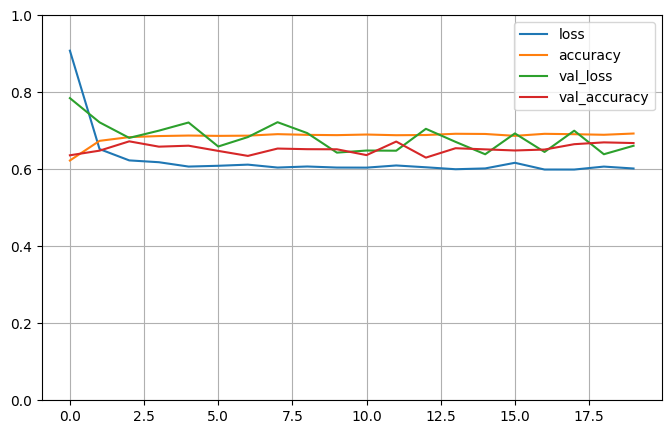

Compute valiation accuracy
2022-10-21 09:03:10.373793
accuracy: 66.81%
2022-10-21 09:03:10.787472
Fold 5
Train sizes 43835 43835
Valid sizes 10516 10516
Thresholds (-0.044162605550458714, -0.044162605550458714)
Train set ones/size 22732 / 43835
Valid set ones/size 5297 / 10516
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-10-21 09:03:10.910460
Epoch 1/20
1370/1370 [==============================] - 4s 2ms/step - loss: 0.9800 - accuracy: 0.6179 - val_loss: 0.7400 - val_accuracy: 0.6371
Epoch 2/20
1370/1370 [==============================] - 3s 2ms/step - loss: 0.6711 - accuracy: 0.6628 - val_loss: 0.6462 - val_accuracy: 0.6591
Epoch 3/20
1370/1370 [==============================] - 3s 2ms/step - loss: 0.6285 - accuracy: 0.6795 - val_loss: 0.6387 - val_accuracy: 0.6751
Epoch 4/20
1370/1370 [==============================] - 3s 2ms/step - loss: 0.6153 - accuracy: 0.6835 - val_loss: 0.5943 - val_accuracy: 0.6945
Epoch 5/20
1370/1370 [==============================] - 3s 2ms/step - loss: 0.61

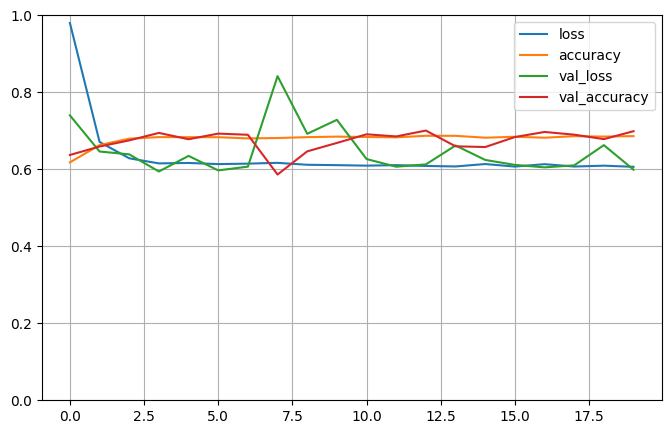

Compute valiation accuracy
2022-10-21 09:04:09.555785
accuracy: 69.89%
2022-10-21 09:04:10.090471

Cross validation acc mean 68.26% (+/- 1.13%)
2022-10-21 09:04:10.098919


In [9]:
print(datetime.now())
do_cross_validation(splitter,EPOCHS)    
print(datetime.now())